<a href="https://colab.research.google.com/github/kushalbakshi/NeuroMatch_Project/blob/main/Steinmetz_Dataset_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
#@title Data loading
import numpy as np
from math import nan

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [41]:
def get_responses_steinmetz(alldat, k):
    #alldat is all the steinmetz data
    #k is the session number that you wish to extract
    dat=alldat[k]
    responses=dat['response']
    feedback= dat['feedback_type']
    contrast_diff = dat['contrast_right']-dat['contrast_left']
    reaction_time = dat['reaction_time']
    brain_area = dat['brain_area']
    spks = dat['spks']
    keys_list = ["resp", "feedback","contrast diff", "reaction_time", "brain_area", "spks"]
    values_list = [responses, feedback, contrast_diff, reaction_time, brain_area, spks]
    zip_iterator = zip(keys_list, values_list)
    global session_responses_dict
    session_responses_dict = dict(zip_iterator)

In [5]:
percent_correct = []
correct_rt = []
incorrect_rt = []
correct_rt_by_contrast = []
incorrect_rt_by_contrast = []

for session_n in range(0,39):
  
  get_responses_steinmetz(alldat, session_n)
  correct_feedback_idx = np.where(session_responses_dict['feedback'] == 1)
  incorrect_feedback_idx = np.where(session_responses_dict['feedback'] == -1)
  reaction_time = np.asarray(session_responses_dict['reaction_time'], dtype='float')
  reaction_time[np.where(np.isposinf(reaction_time[:,0]) == 1), 0] = nan
  correct_rt.append(np.nanmean(reaction_time[correct_feedback_idx, 0]))
  incorrect_rt.append(np.nanmean(reaction_time[incorrect_feedback_idx, 0]))
  
  for n in np.arange(-1, 1.2, 0.25):
    contrast_idx = np.where(session_responses_dict['contrast diff'] == n)
    temp_percent_correct = session_responses_dict['feedback'][contrast_idx] == 1
    percent_correct.append(temp_percent_correct.mean()*100)

    temp_correct_rt_by_contrast = np.nanmean(reaction_time[np.where(temp_percent_correct == 1), 0])
    temp_incorrect_rt_by_contrast = np.nanmean(reaction_time[np.where(temp_percent_correct == 0), 0])
    correct_rt_by_contrast.append(temp_correct_rt_by_contrast)
    incorrect_rt_by_contrast.append(temp_incorrect_rt_by_contrast)

total_mean_correct = np.mean(np.reshape(percent_correct, (9, 39), order='F'), axis=1)
total_error = np.std(np.reshape(percent_correct, (9, 39), order='F'), axis=1)
mean_incorrect_rt_by_contrast = np.nanmean(np.reshape(incorrect_rt_by_contrast, (9, 39), order='F'), axis=1)
mean_correct_rt_by_contrast = np.nanmean(np.reshape(correct_rt_by_contrast, (9, 39), order='F'), axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


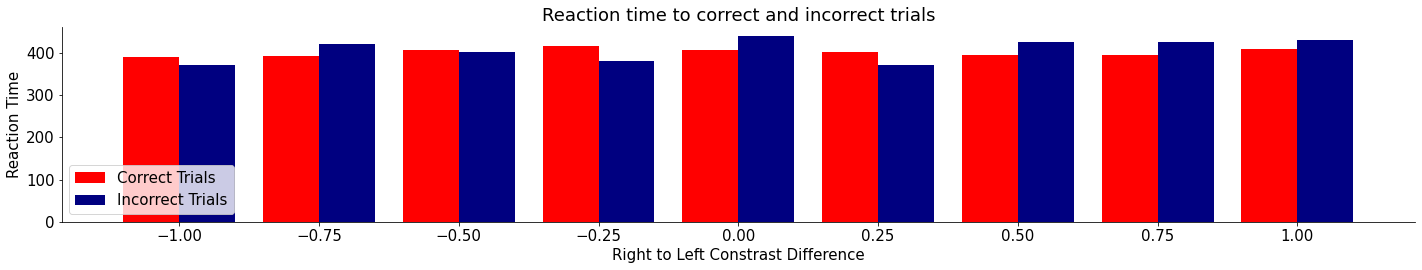

In [39]:
from matplotlib.cbook import get_label
LR_contrast = np.arange(-1, 1.2, 0.25)
colors = ('red', 'navy')
for n in range(0, len(LR_contrast)):
  plt.bar(LR_contrast[n]-0.05, mean_correct_rt_by_contrast[n], width=0.1, color=colors[0])
  plt.bar(LR_contrast[n]+0.05, mean_incorrect_rt_by_contrast[n], width=0.1, color=colors[1])
  plt.xticks(ticks=LR_contrast)
  plt.xlabel('Right to Left Constrast Difference')
  plt.ylabel('Reaction Time')
  plt.title('Reaction time to correct and incorrect trials')
  plt.legend(('Correct Trials', 'Incorrect Trials'), loc='lower left')

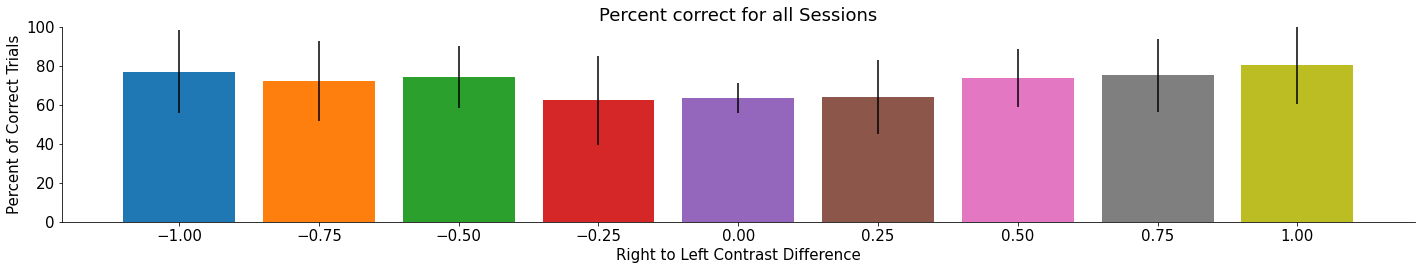

In [40]:
LR_contrast = np.arange(-1, 1.2, 0.25)
for n in range(0, len(LR_contrast)):
  plt.bar(LR_contrast[n], total_mean_correct[n], width=0.2, label=LR_contrast[n], yerr = total_error[n])
plt.xticks(ticks=LR_contrast);
plt.xlabel('Right to Left Contrast Difference')
plt.ylabel('Percent of Correct Trials')
plt.title('Percent correct for all Sessions')
plt.ylim(0, 100);

In [42]:
get_responses_steinmetz(alldat, 11)
visp_spikes = session_responses_dict['spks'][session_responses_dict['brain_area'] == 'VISp']

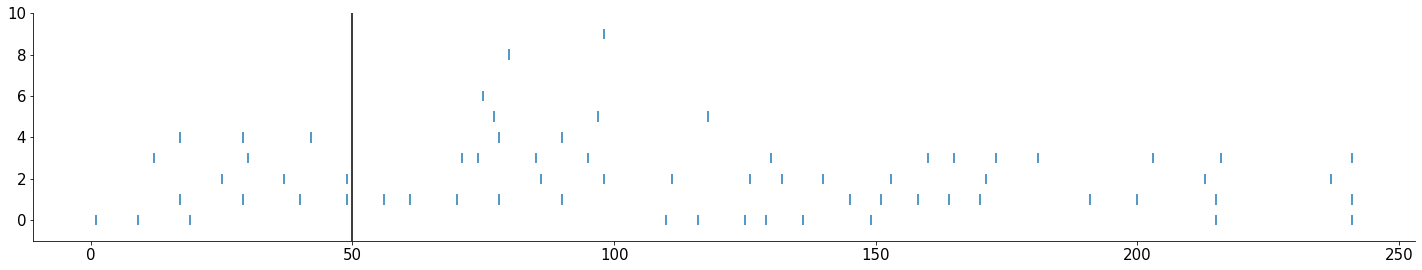

In [68]:
# Data Structure is visp_spikes[neuron_number][trial_number]
bin_size = 10
stimulus_onset = 500/bin_size
for n in range(0, 10):
  plt.eventplot(np.where(visp_spikes[0][n] == 1), lineoffsets=n, linelengths=0.5)
plt.axvline(x=stimulus_onset, color='black')